In [1]:
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from pathlib import Path
from matplotlib import cm
from matplotlib.colors import Normalize

Fig 3a

(-0.5, 15.0)

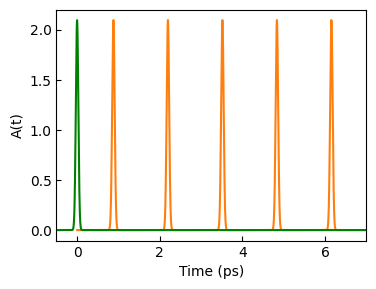

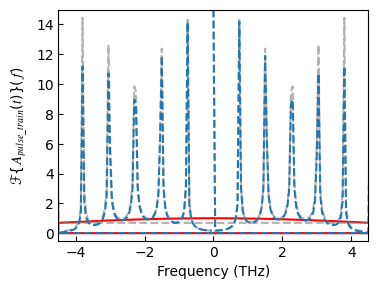

In [6]:
def theor_fft_1(tau):

    sigma = (0.03 / t_in_ps)    # Standard deviation of the Gaussian pulses
    total_time = 20/t_in_ps  # Total time window
    
    t = np.linspace(0, total_time, 20000)
    t_sym = np.linspace(-total_time, total_time, 20000)
    num_pulse = 5
    pulse_1 = np.zeros_like(t)
    
    for i in range (0, num_pulse):
        pulse_1 += np.exp(-((t - i*tau - tau/1.5) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

    pulse_t0 = np.exp(-((t_sym) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))
    fft_pulse_1 = np.fft.fft(pulse_1-np.mean(pulse_1))
    fft_freq_1 = np.fft.fftfreq(len(t), d=(t[1] - t[0])*t_in_ps)
    
    # consider fft, F(t) = Gaussian term, G_f * Modulation term, M_f
    # Calculate the Gaussian term
    G_f = np.exp(-2 * np.pi**2 * sigma**2 * fft_freq_1**2 * t_in_ps**2) 
    num_pulses = int(total_time // tau)
    phase_shift = np.exp(-1j * 2 * np.pi * fft_freq_1 * tau / 1.5 * t_in_ps)
    geom_sum = np.sum([np.exp(-1j * 2 * np.pi * fft_freq_1 * tau * t_in_ps * n) for n in range(num_pulses)], axis=0)
    M_f = phase_shift * geom_sum
    
    # Combined theoretical FT
    S_f = G_f * M_f
    return pulse_t0, pulse_1, fft_freq_1, G_f, M_f, S_f

freq_in_thz = 6.3507799295888985 # converts w=sqrt(k/m) in sqrt(THz/(Angstrom^2 * atomic mass unit)) to THz
t_in_ps = 1 / freq_in_thz
t_sym = np.linspace(-20/t_in_ps, 20/t_in_ps, 20000)
tau1=2*0.32962/t_in_ps
tau2=4*0.32962/t_in_ps
total_time = 20/t_in_ps  # Total time window
t = np.linspace(0, total_time, 20000)
pulse_t0, pulse2, fft_freq2, G_f2, M_f2, S_f2 = theor_fft_1(tau2)
ifft_gf = np.fft.ifft(G_f2)

alpha=0.5
plt.figure(figsize = (4,3))
plt.plot(t*t_in_ps, pulse2, color='C1')
plt.plot(t_sym*t_in_ps, pulse_t0, color='green')
plt.xlabel('Time (ps)')
plt.ylabel('A(t)')
plt.xlim(-0.5,7)
plt.tick_params(direction='in')
#plt.savefig('Final_figs/Fig3/Fig3a_2.pdf', bbox_inches='tight')

plt.figure(figsize = (4,3))

plt.plot(fft_freq2, G_f2, color='red')
plt.plot(fft_freq2, np.abs(M_f2), color='gray', linestyle='--', alpha=0.6)
plt.plot(fft_freq2, np.abs(S_f2), color='C0', linestyle='--')
plt.xlabel('Frequency (THz)')
plt.ylabel('$ℱ\{𝐴_{𝑝𝑢𝑙𝑠𝑒\_𝑡𝑟𝑎𝑖𝑛} (𝑡)\}(𝑓)$')
plt.tick_params(direction='in')
plt.xlim(-4.5,4.5)
plt.ylim(-0.5,15)
#plt.savefig('Final_figs/Fig3/Fig3a_1.pdf', bbox_inches='tight')


Fig 3b

(180, 70) (180,)


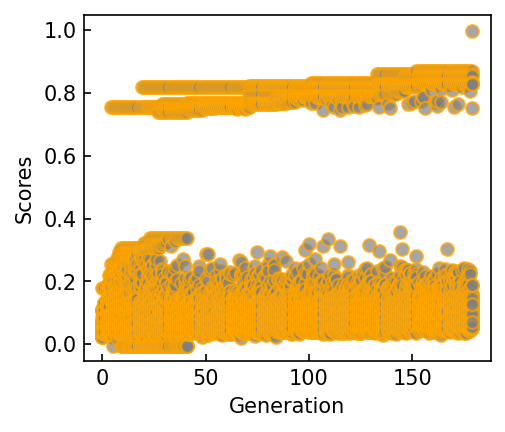

In [4]:
# Fig 3b---- Scores vs generation

scores = np.loadtxt('Data/scores_3b.dat')
gen_no = np.loadtxt('Data/gen_3b.dat')

n_pop=70

print(scores.shape, gen_no.shape)

fig3b, ax2 = plt.subplots(figsize=(3.5, 3), dpi=150, facecolor='white')
cmap = cm.viridis_r

# Scatter plot with colormap based on rank
for i in range(gen_no.shape[0]):
    ranks = np.argsort(np.argsort(scores[i, :]))
    norm = Normalize(vmin=ranks.min(), vmax=ranks.max())
    colors_score = cmap(norm(ranks))

    #ax2.scatter([np.log(gen_no[i]+1)] * n_pop, scores[i], alpha=0.7, edgecolor='orange', color='grey', s=38)
    ax2.scatter([gen_no[i]] * n_pop, scores[i], alpha=0.7, edgecolor='orange', color='grey', s=38)

ax2.set_xlabel('Generation')
ax2.set_ylabel('Scores')
ax2.tick_params(direction='in')
#plt.savefig('Fig3b.pdf', bbox_inches='tight')

Fig 3cd

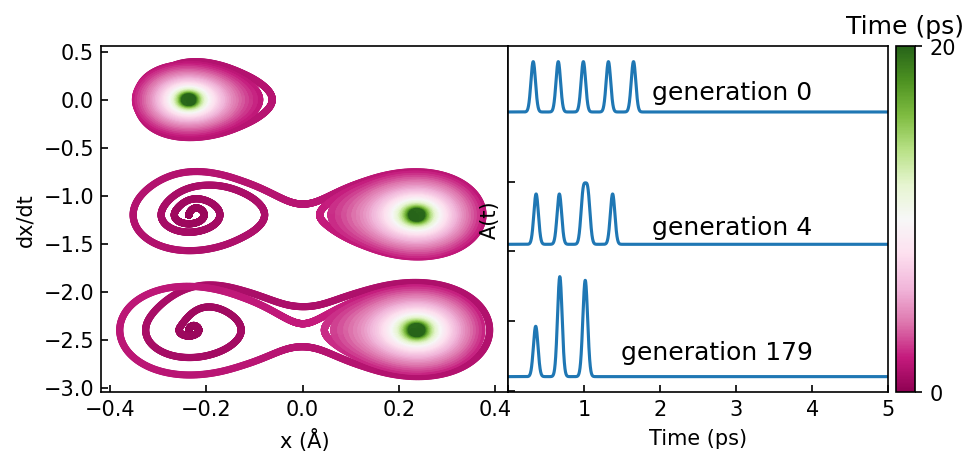

In [31]:
# Fig 3cd---- Phase space + Protocols
from mpl_toolkits.axes_grid1 import make_axes_locatable

sol_x_all = np.loadtxt('Data/sol_x_3c.dat')
sol_v_all = np.loadtxt('Data/sol_v_3c.dat')
At_all = np.loadtxt('Data/protocol_3d.dat')

freq_in_thz = 6.3507799295888985 # converts w=sqrt(k/m) in sqrt(THz/(Angstrom^2 * atomic mass unit)) to THz
t_in_ps = 1 / freq_in_thz

tspan = [0, 20/t_in_ps]
tfine = np.linspace(*tspan, 20000)
norm2 = Normalize(vmin=np.min(tfine*t_in_ps), vmax=np.max(tfine*t_in_ps))

fig3cd, (ax3,ax4) = plt.subplots(1,2,figsize=(7, 3), dpi=150, facecolor='white')

for idx in range(len(sol_x_all)-1,-1,-1):
    sc=ax3.scatter(sol_x_all[idx], sol_v_all[idx]-1.2*idx, c = tfine*t_in_ps, cmap='PiYG', edgecolor='none', norm=norm2, s=12)
    ax4.plot(tfine*t_in_ps, At_all[idx]-0.95*idx, color='C0', label=f'gen {idx+1}')

ax3.set_xlabel('x (Å)')
ax3.set_ylabel('dx/dt')
ax3.tick_params(direction='in')

divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.set_position([0.8, 0.2, 0.03, 0.6])
cbar = fig3cd.colorbar(sc, cax=cax,orientation='vertical')
cbar.ax.set_title('Time (ps)')
cbar.set_ticks([norm2.vmin, norm2.vmax])
cbar.ax.set_yticklabels(['0', '20'])

ax4.set_xlabel('Time (ps)')
ax4.set_ylabel('A(t)', labelpad=0.5)
ax4.set_xlim(0,5)
ax4.tick_params(direction='in')

ax4.text(0.80, 0.90, "generation 0", transform=ax4.transAxes,fontsize=12, va='top', ha='right')
ax4.text(0.80, 0.51, "generation 4", transform=ax4.transAxes,fontsize=12, va='top', ha='right')
ax4.text(0.80, 0.15, "generation 179", transform=ax4.transAxes,fontsize=12, va='top', ha='right')
ax4.set_yticklabels([])
xticks_positions = ax4.get_xticks()
xticks_labels = ax4.get_xticklabels()
xticks_labels = [''] + [label.get_text() for label in xticks_labels[1:]]
ax4.set_xticks(xticks_positions)
ax4.set_xticklabels(xticks_labels)

plt.subplots_adjust(wspace=0)
#plt.savefig('Fig3cd.pdf', bbox_inches='tight')